In [1]:
gpu_use = TRUE

library(reticulate, quietly = TRUE)

if (gpu_use){
    device <- 'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device <- NULL
}

In [2]:
suppressPackageStartupMessages({
    library(splatter, quietly = T)
    
    library(scater, quietly = T)
    library(scran, quietly = T)
    library(bluster, quietly = T)
    
    library(BBmisc, quietly = T)
    
    library(liana, quietly = T)
    
    library(aricode, quietly = T)
    library(kBET, quietly = T)
    
    library(zellkonverter, quietly = T)
    
    library(reticulate, quietly = T)
    scanorama <- import('scanorama')
    scvi <- import("scvi", convert = FALSE)
    c2c <- reticulate::import(module = "cell2cell", as="c2c")
})

source('../simulation_functions.r')

In [2]:
seed = 888
set.seed(seed)

env.name<-'tc2c_benchmark'
data.path<-'/data/hratch/ccc_protocols/'
n.cores<-48

return_all = TRUE
repeat_rank = FALSE # whether to re-calculate tensor rank each iteration
cluster_tol = 2 # louvain # of clusters tolerance (see cluster.range parameter in search.clusters)
# RhpcBLASctl::blas_set_num_threads(n.cores)

# Functions

In [4]:
add.context.noise<-function(sim, context.noise, contexts){
    colData(sim)[['Context']]<-NULL
    for (i in seq_along(contexts)){
        context.cells<-contexts[[i]]
        noise.sim<-context.noise[[i]]

        counts(sim)[, context.cells] <- as.matrix(counts(sim)[, context.cells] + counts(noise.sim))
        colData(sim)[context.cells, 'Context']<-paste0('Context_', i)
    }
    return(sim)
}

scanorama.batch.correct<-function(sce.batch){

    # prep scanorama inputs - split expression objects by batch
    batches<-list()
    genes<-list()
    for (batch in unique(colData(sce.batch)$Batch)){
        cells.in.batch<-rownames(colData(sce.batch)[colData(sce.batch)$Batch == batch,])
        sce.singlebatch<-sce.batch[, cells.in.batch]

        batches[[batch]]<-t(assays(sce.singlebatch)$logcounts) # cells x genes
        genes[[batch]]<-as.list(rownames(sce.batch))
    }

    # do the batch correction 
    corrected.data <- scanorama$correct(unname(batches), unname(genes), return_dense=TRUE)

    # format into the sce
    genes<-corrected.data[[2]]
    corrected.data<-corrected.data[[1]]

    for (i in 1:length(corrected.data)){
        expr<-corrected.data[[i]]
        colnames(expr) <- genes
        rownames(expr) <- rownames(batches[[i]])
        corrected.data[[i]] <- t(expr)
    }
    corrected.data <- do.call(cbind, corrected.data)

    if (!identical(dim(corrected.data), dim(assays(sce.batch)$logcounts))){ # sanity check
        stop('Unexpected filters in scanorama batch correction')
    }
    corrected.data<-corrected.data[rownames(assays(sce.batch)$logcounts), colnames(assays(sce.batch)$logcounts)]
    assays(sce.batch)[['batch.corrected.counts']] <- corrected.data
    
    return(sce.batch)
}

scvi.batch.correct<-function(sce.batch, seed = 888){
    
    scvi$settings$seed = as.integer(seed)
    
    if (!gpu_use){
        scvi$settings$num_threads = as.integer(1)
        scvi$settings$dl_num_workers = as.integer(n.cores)
    }

    adata.batch<-zellkonverter::SCE2AnnData(sce.batch, X_name = 'logcounts') # specifying this stores raw UMI counts in "counts" layer
    reticulate::py_set_seed(as.integer(seed))
    scvi$model$SCVI$setup_anndata(adata.batch, layer = 'counts', batch_key = 'Batch')
    model = scvi$model$SCVI(adata.batch, n_layers = 2L, n_latent = 30L, gene_likelihood= "nb") # non-default args - 
    model$train()

    # library size and log1p make it similar to log(1+CPM) normalization, but with batch correction
    # batch corrected counts: https://discourse.scverse.org/t/how-to-extract-batch-corrected-expression-matrix-from-trained-scvi-vae-model/151
    corrected.data = model$get_normalized_expression(transform_batch = sort(unique(colData(sce.batch)$Batch)),
                                                    library_size = 1e6)
    corrected.data<-t(log1p(reticulate::py_to_r(corrected.data)))

    if (!identical(dim(corrected.data), dim(assays(sce.batch)$logcounts))){ # sanity check
            stop('Unexpected filters in scvi batch correction')
        }
    
    assays(sce.batch)[['batch.corrected.counts']] <- corrected.data
    return(sce.batch)
    
}

do.batch.correction<-function(sce.batch){
    sce.scanorama<-scanorama.batch.correct(sce.batch)
    sce.scvi<-scvi.batch.correct(sce.batch)
    sce.batches<-list(sim.scanorama = sce.scanorama, sim.scvi = sce.scvi)
    
    # remove PCA from log assay to ensure that it is re-run
    for (i in 1:length(sce.batches)){
        sce<-sce.batches[[i]]
        reducedDims(sce)<-list()
        sce.batches[[i]]<-sce
    }
    return(sce.batches)
}

search.clusters<-function(sce, n.cell.types, cluster.range = 0, iter.limit = 20, verbose = F){
    res.param<-1
    clusters<-scran::clusterCells(sce, use.dimred="PCA", 
                        BLUSPARAM=NNGraphParam(shared = T, cluster.fun="louvain", 
                                              cluster.args=list(resolution=res.param))) 
    n.clusters<-length(unique(clusters))
    if (verbose){print(paste0('Resolution: ', res.param,'; # of clusters', n.clusters))}
    
    iter <- 1
    while (!(n.clusters %in% ((n.cell.types-cluster.range):(n.cell.types+cluster.range)))){
        if (n.clusters < n.cell.types){
            res.param = res.param*2
            clusters<-scran::clusterCells(sce, use.dimred="PCA", 
                        BLUSPARAM=NNGraphParam(shared = T, cluster.fun="louvain", 
                                              cluster.args=list(resolution=res.param)))
            n.clusters<-length(unique(clusters))
            if (verbose){print(paste0('Iteration: ', iter, '; resolution: ', res.param,'; # of clusters', n.clusters))}
        }
        else{
            res.param = res.param/10
            clusters<-scran::clusterCells(sce, use.dimred="PCA", 
                        BLUSPARAM=NNGraphParam(shared = T, cluster.fun="louvain", 
                                              cluster.args=list(resolution=res.param)))
            n.clusters<-length(unique(clusters))
            if (verbose){print(paste0('Iteration: ', iter, '; resolution: ', res.param,'; # of clusters', n.clusters))}
        }
        if (iter > iter.limit){
            print('Too many iterations when searching for cluster resolution')
            clusters<-NULL
            break
        }
        iter<-iter + 1
    }
    return(clusters)
}

cluster.cells<-function(sce, assay.type, n.cell.types, cluster.method = 'kmeans', ...){
    if (!('PCA' %in% reducedDimNames(sce))){
        sce <- scran::fixedPCA(sce, assay.type = assay.type, subset.row=NULL) # default 50 PCs
    }
    # clustering http://bioconductor.org/books/3.13/OSCA.basic/clustering.html
    
    if (cluster.method == 'kmeans'){
        colData(sce)[[paste0('Cluster.', cluster.method)]]<-scran::clusterCells(sce, use.dimred="PCA", 
                                                       BLUSPARAM=KmeansParam(centers = n.cell.types)) 
    } else if (cluster.method == 'louvain'){
#         if (!is.null(clusters)){
        colData(sce)[[paste0('Cluster.', cluster.method)]]<-search.clusters(sce, n.cell.types, ...)
    }
    return(sce)
}

# for setting cluster.method to snn, if didn't get clusters because # of clusters != # of cell types
check.cluster<-function(sce){
    cluster.present<-T
    cluster.method<-'louvain'
    if (!(paste0('Cluster.', cluster.method) %in% colnames(colData(sce)))){cluster.present = F}
    return (cluster.present)
}

quantify.batch.effect<-function(sce, assay.type){
    batch.severity<-list()
    
    
    # clusterability
    batch.severity[['clusterability.kmeans']]<-(1-aricode::NMI(colData(sce)$Group, colData(sce)[['Cluster.kmeans']])) 
    if (check.cluster(sce)){
        batch.severity[['clusterability.louvain']]<-(1-aricode::NMI(colData(sce)$Group, colData(sce)[['Cluster.louvain']])) 
    }else{
        batch.severity[['clusterability.louvain']]<-NA
    }
    
    batch.severity[['mixability']]<-kBET(df = t(assays(sce)[[assay.type]]), batch = colData(sce)$Batch, # mixability
                        plot = F)$summary['mean', 'kBET.observed']
    # sil.cluster <- as.data.frame(silhouette(as.numeric(colData(sce)$Cluster), 
    #                               dist(reducedDims(sce)$PCA)))
    # sil.cluster<-mean(aggregate(sil.cluster[, 'sil_width'], list(sil.cluster$cluster), mean)$x)

    return(batch.severity)
}

count.negative<-function(df){
    return(length(df[df<0])/length(df))
}
# only have the from and to assay params because 
# liana errors out if setting assay.type = batch.corrected.counts
# so this is a hacky way around that
replace.negative.counts<-function(sce, fill_val = 0, 
                                  from_assay = 'batch.corrected.counts', 
                                 to_assay = 'logcounts'){
    df<-assays(sce)[[from_assay]]
    df[df<0]<-fill_val
    assays(sce)[[to_assay]]<-df  
    return(sce)
}

# Baseline

## Baseline parameters

In [5]:
base_params <- newSplatParams()
n.cells<-5e3
n.cell.types<-6
n.genes<-2e3
n.lrs<-2e2
n.contexts<-5

n.batches<-1 

baseline_params <- setParams(
    base_params,
    seed = seed,
    nGenes = n.genes,
    
    # batches - introduce mild ones to have context-driven changes since will treat batch as context
    batchCells = rep(n.cells/n.batches, n.batches),
    batch.rmEffect = TRUE, 
    batch.facLoc = 0, # higher values increase batch severity
    batch.facScale = 0, # higher values increase batch severity
    # cell types
    group.prob = rep(1/n.cell.types, n.cell.types), 
    de.facLoc = 0.65, # increase separation between cell types
    de.facScale = 0.1 # increase separation between cell types
)

## Context-specific effects

First, we will create a dataset with no batch effects and all the cell types well separated: 

In [6]:
sim.baseline<-splatSimulateGroups(baseline_params, verbose = F)

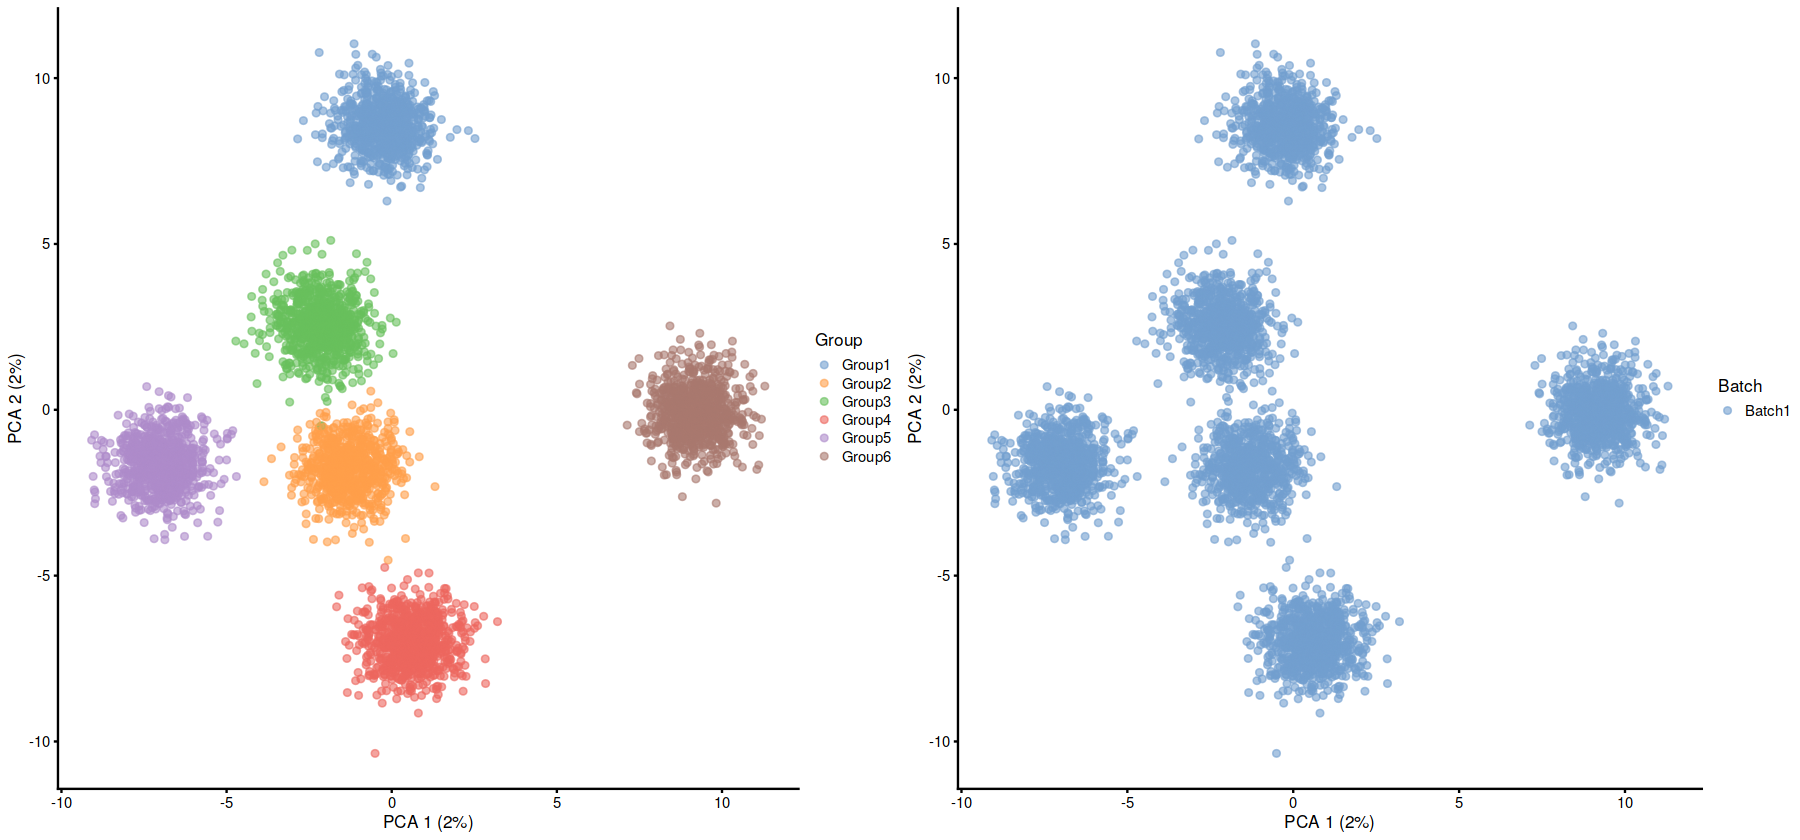

In [7]:
sim.baseline.viz<-sim.baseline

sim.baseline.viz <- qc.data(sim.baseline.viz)
sim.baseline.viz <- scater::logNormCounts(sim.baseline.viz)
sim.baseline.viz <- scran::fixedPCA(sim.baseline.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs

h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(sim.baseline.viz, colour_by = "Group")
g1b<-plotPCA(sim.baseline.viz, colour_by = "Batch")

g1<-ggpubr::ggarrange(g1a, g1b, ncol = 2)
# for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'batch_effect_baseline', ext), g1, 
#                                              height = h_, width = w_)}
g1

Next, we add some context-specific noise to create a tensor that will have multiple factors. 

This context-specific noise will be added to each simulation.

In [8]:
set.seed(seed)
contexts <- BBmisc::chunk(colnames(sim.baseline),
                                    chunk.size = n.cells/n.contexts,
                                    shuffle = TRUE)

context.noise<-list()
for (i in seq_along(contexts)){
    context.cells<-contexts[[i]]
    
    noise.sim <- splatSimulate(
                nGenes = n.genes,
                batchCells = length(context.cells),
                lib.loc    = 6,
                lib.scale  = 0.6,
                verbose    = FALSE,
                seed       = seed+i
            )
    context.noise[[i]]<-noise.sim
}
sim.baseline.context<-add.context.noise(sim.baseline, context.noise, contexts)

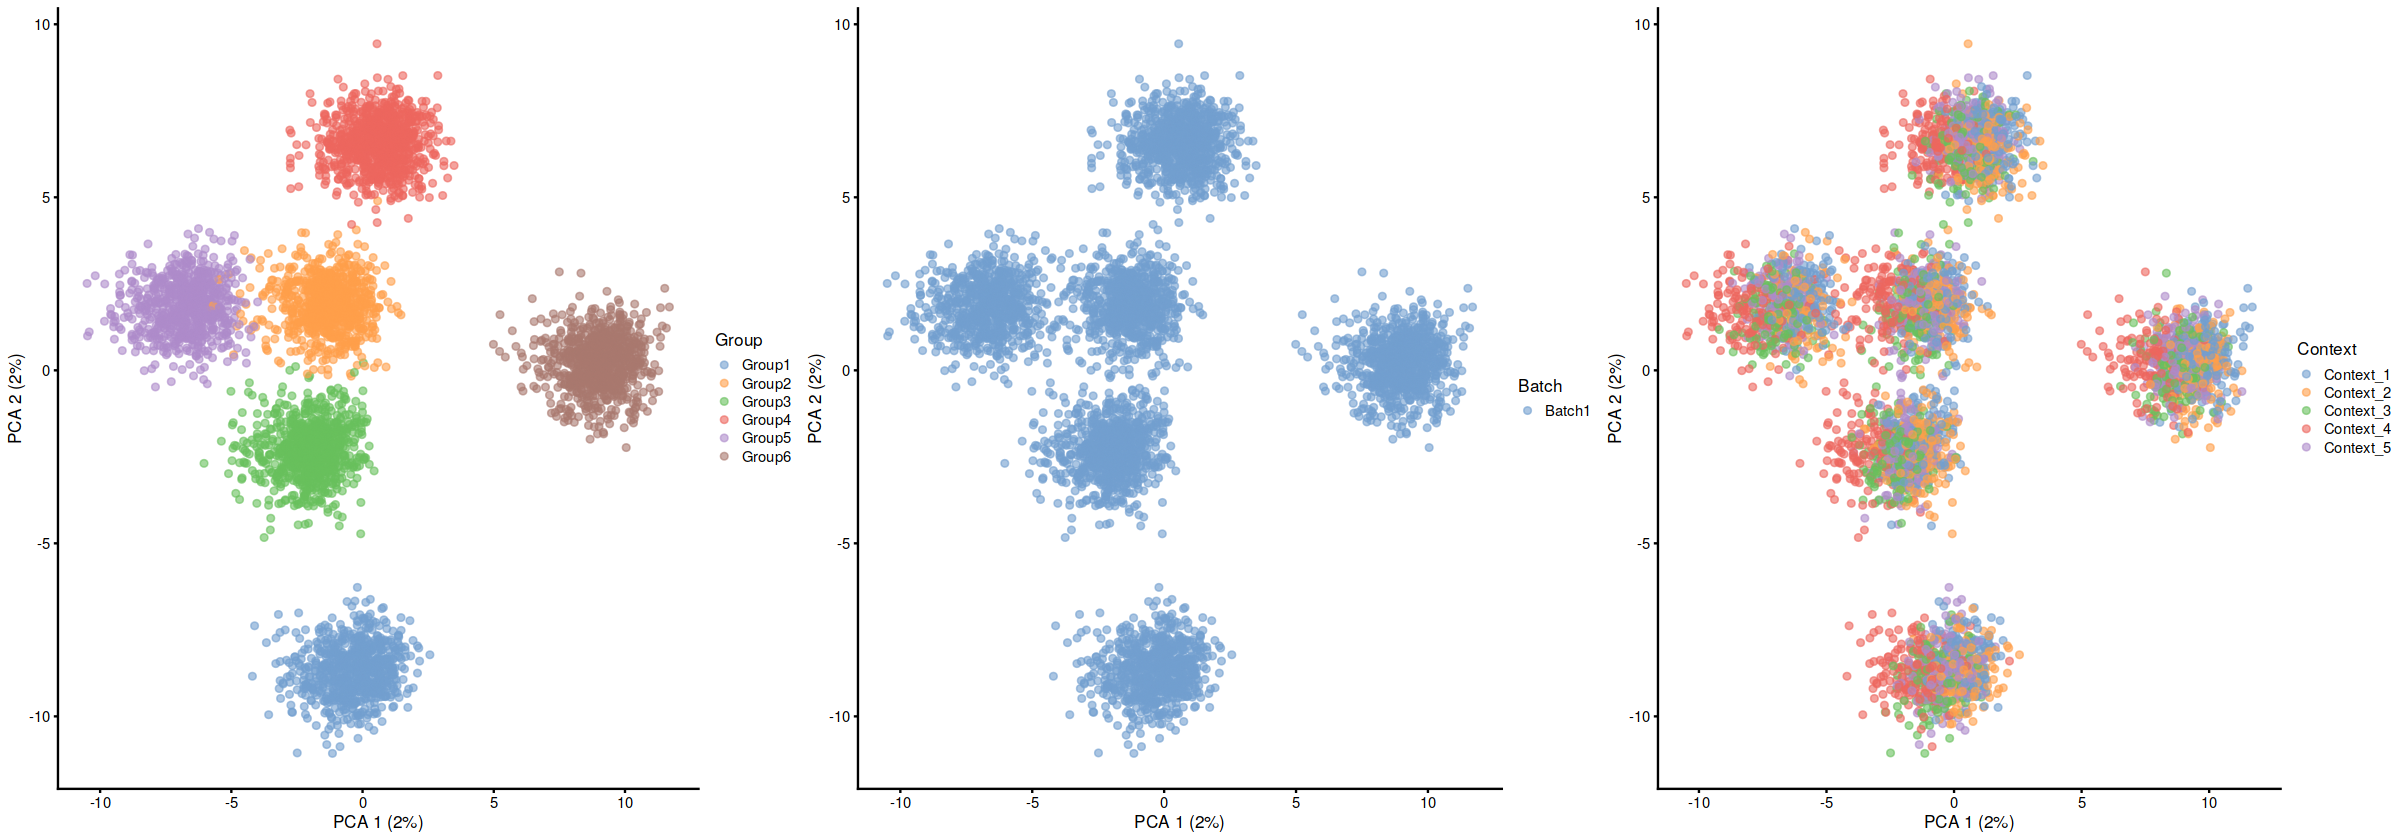

In [9]:
sim.viz<-sim.baseline.context
sim.viz<-qc.data(sim.viz)
sim.viz <- scater::logNormCounts(sim.viz)
sim.viz <- scran::fixedPCA(sim.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs

h_ = 7
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g2a<-plotPCA(sim.viz, colour_by = "Group")
g2b<-plotPCA(sim.viz, colour_by = "Batch")
g2c<-plotPCA(sim.viz, colour_by = "Context")


g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3)
# for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'batch_effect_baseline_context', ext), g2, 
#                                              height = h_, width = w_)}
g2

In [10]:
df<-data.frame(colData(sim.baseline.context))
cell.counts<-ddply(df, .(df$Context, df$Group), nrow)
reshape2::dcast(df, Context ~ Group)

Using Context as value column: use value.var to override.

Aggregation function missing: defaulting to length



Context   Group1 Group2 Group3 Group4 Group5 Group6
1 Context_1 153    152    171    174    169    181   
2 Context_2 157    161    184    181    136    181   
3 Context_3 147    151    195    166    165    176   
4 Context_4 180    170    143    181    165    161   
5 Context_5 166    161    160    191    148    174

## LR simulation

In [11]:
# generate a LR PPI on a subset of the genes
set.seed(seed)
lr.genes<-sort(as.character(sample(rownames(sim.baseline.context), size = n.lrs, replace = FALSE)))
lr.ppi<-generate.lr.ppi(lr.genes)
interacting.lr.genes<-unique(c(lr.ppi$source_genesymbol, lr.ppi$target_genesymbol))

## Expected Tensor Rank

In [12]:
sim.baseline.context.list<-split.by.context(sim.baseline.context, context_lab = 'Context') 

# log-normalize
sim.baseline.context.list<-lapply(sim.baseline.context.list, FUN = function(sce) {
    sce <- scater::logNormCounts(sce)
})

# score communication
scores.baseline.context<-list()
for (context in names(sim.baseline.context.list)){
    scores.baseline.context[[context]]<-score.communication(sce_ = sim.baseline.context.list[[context]], 
                                   method = c('cellphonedb', 'natmi', 'sca'), # only the ones with a magnitude score
                                   idents_col = 'Group', # cells
                                   assay.type = 'logcounts',
                                   return_all = return_all, 
                                   expr_prop = 0.05, 
                                   seed = seed,
                                   parallelize = T, 
                                   workers = n.cores, 
                                   permutation.params = list(nperms = 1), # since we don't use p-values
                                   resource = 'custom',
                                   external_resource = lr.ppi)
}

# this could possibly happen, in which case the zeros filling in needs to be done always
if (return_all){
    if (length(unique(sapply(scores.baseline.context, function(x) dim(x)[[1]]))) != 1){
        stop("Unexpected # of interactions b/w samples despite 'return_all' being TRUE")
    } 
}
                            
if (!return_all){stop('See missing indices script to handle this scenario')}

Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours.”


In [13]:
# # build and decompose tensor
# tensor.baseline.context<-liana_tensor_c2c(context_df_dict = scores.baseline.context,
#                                score_col = 'score',
#                                ligand_col = 'ligand', 
#                                receptor_col = 'receptor', 
#                                lr_fill = NaN, 
#                                cell_fill = NaN,
#                                how = 'outer',
#                                seed = seed, 
#                                conda_env = env.name,
#                                device = NULL,
#                                build_only = T)

# if (gpu_use){
#     tensorly$set_backend('pytorch')
#     tensor.baseline.context$to_device('cuda')
# }
                 
# # identify the rank and run the decomposition
# tensor.baseline.context<-liana::decompose_tensor(tensor = tensor.baseline.context,
#                                        rank = NULL, 
#                                        tf_optimization = 'robust', 
#                                        seed = seed, 
#                                        upper_rank = 25, 
#                                        init = 'svd', 
#                                        factors_only = F, 
#                                        ) # estimate the rank by setting to NULL
# print(paste0('The rank for the gold standard tensor is ', tensor.baseline.context$rank))
# if (gpu_use)({tensorly$set_backend('numpy')}) # need to change back to be able to manipulate masks, etc
    
# reticulate::py_save_object(object = tensor.baseline.context,
#                            filename = file.path(data.path, 
#                                                 'interim/batchcorrection_base_tensor.pkl'))

tensor.baseline.context <- reticulate::py_load_object(filename = file.path(data.path, 
                                                'interim/batchcorrection_base_tensor.pkl'))


### Visualize decomposition

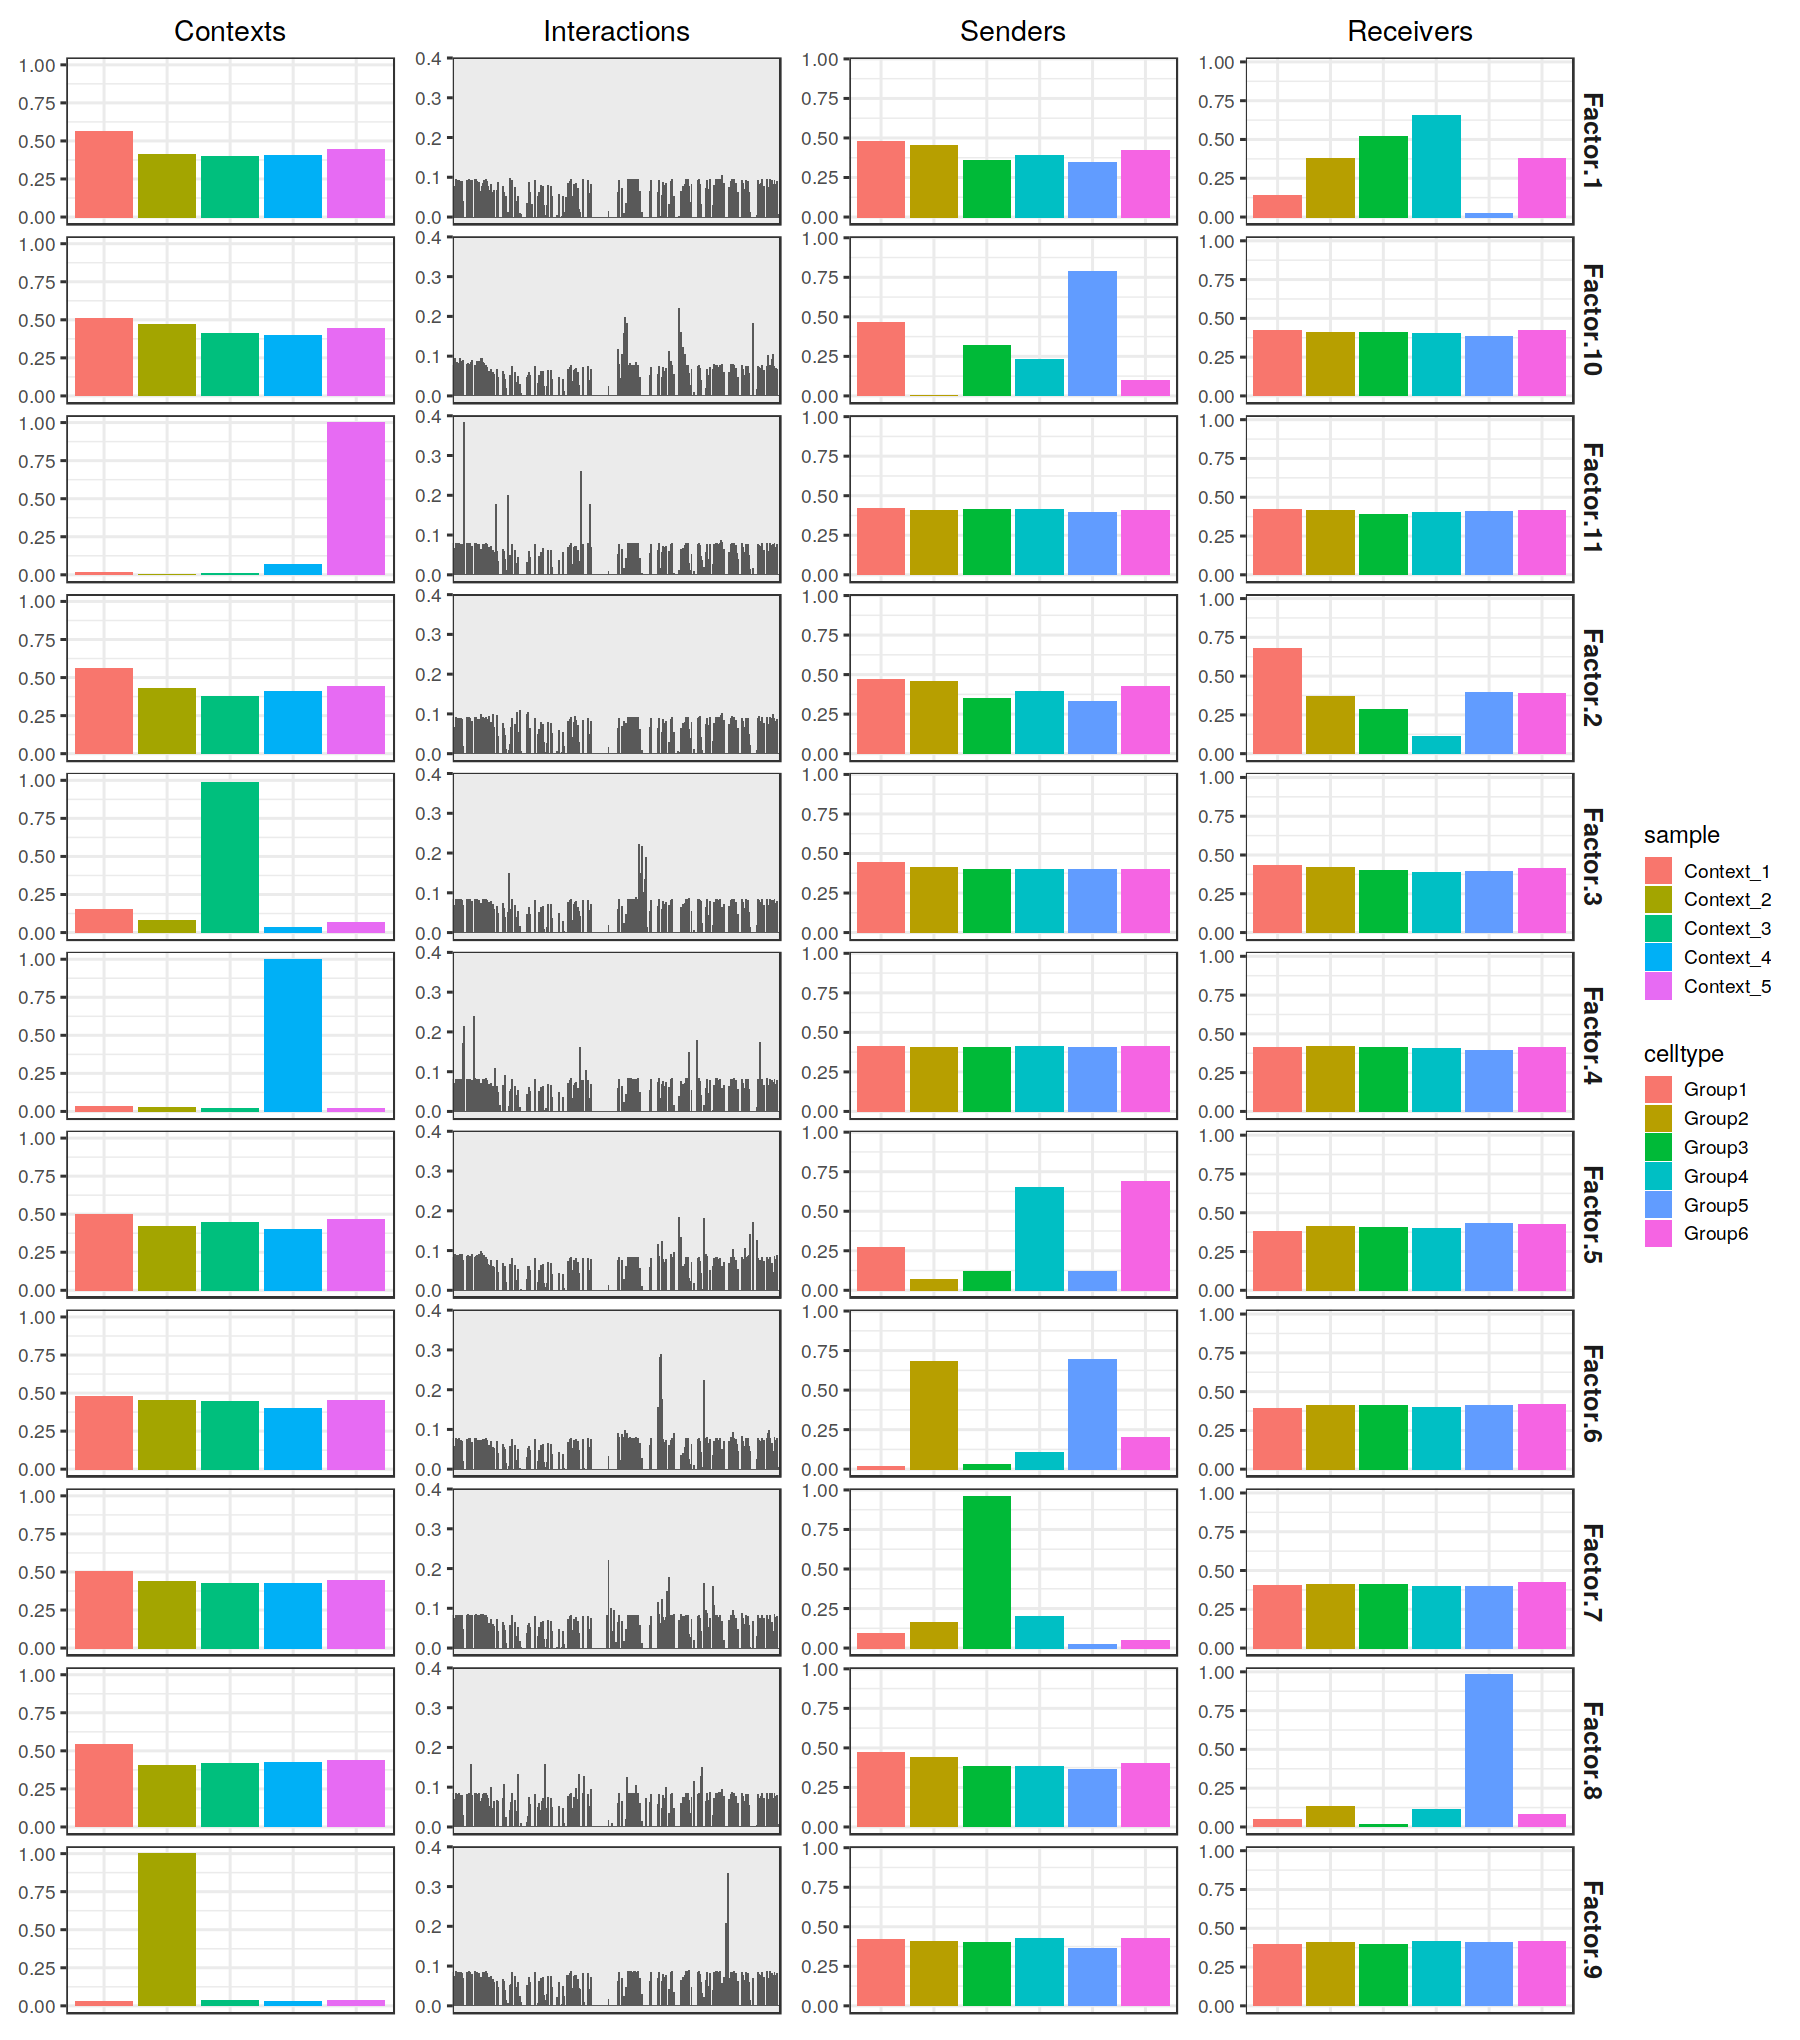

In [14]:
h_ = 17
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

sim.baseline.context.viz<-sim.baseline.context
sim.baseline.context.viz@colData[['sample']]<-sim.baseline.context.viz@colData$Context
sim.baseline.context.viz@metadata$tensor_res<-liana:::format_c2c_factors(tensor.baseline.context$factors)
plot_c2c_overview(sim.baseline.context.viz, sample_col = 'Context', group_col = 'sample')

# Example of an iteration

Here is what the baseline params with an actual batch effect simulation looks like:

In [15]:
iter.params.list = list()
iter.params.list[[1]] = list(n.batches = 2, batch.scale = 0.25, batch.location = 0.25)
iter.params<-iter.params.list[[1]]
# with batch effects
sim_params <- setParams(
    baseline_params,
    
    # batches
    batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
    batch.facLoc = iter.params$batch.location, # higher values increase batch severity
    batch.facScale = iter.params$batch.scale, # higher values increase batch severity
    batch.rmEffect = FALSE, # create the gold standard when set to True

)

sim<-splatSimulateGroups(sim_params, verbose = F)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

# add noise
expr.datasets.nc<-expr.datasets
expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, 
                                                                           context.noise, 
                                                                           contexts))
                      
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scater::logNormCounts(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scater::logNormCounts(sce))
                         
intersect.cells<-Reduce(intersect, list(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold), 
                       colnames(expr.datasets.nc$sim.log), colnames(expr.datasets.nc$sim.gold)))
expr.datasets<-lapply(expr.datasets, FUN = function(sce) sce[, intersect.cells])
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) sce[, intersect.cells])
                         
for (i in seq_along(expr.datasets.nc)){
    sce<-expr.datasets.nc[[i]]
    colData(sce)[['Context']] = colData(expr.datasets$sim.log)$Context
    expr.datasets.nc[[i]]<-sce
}

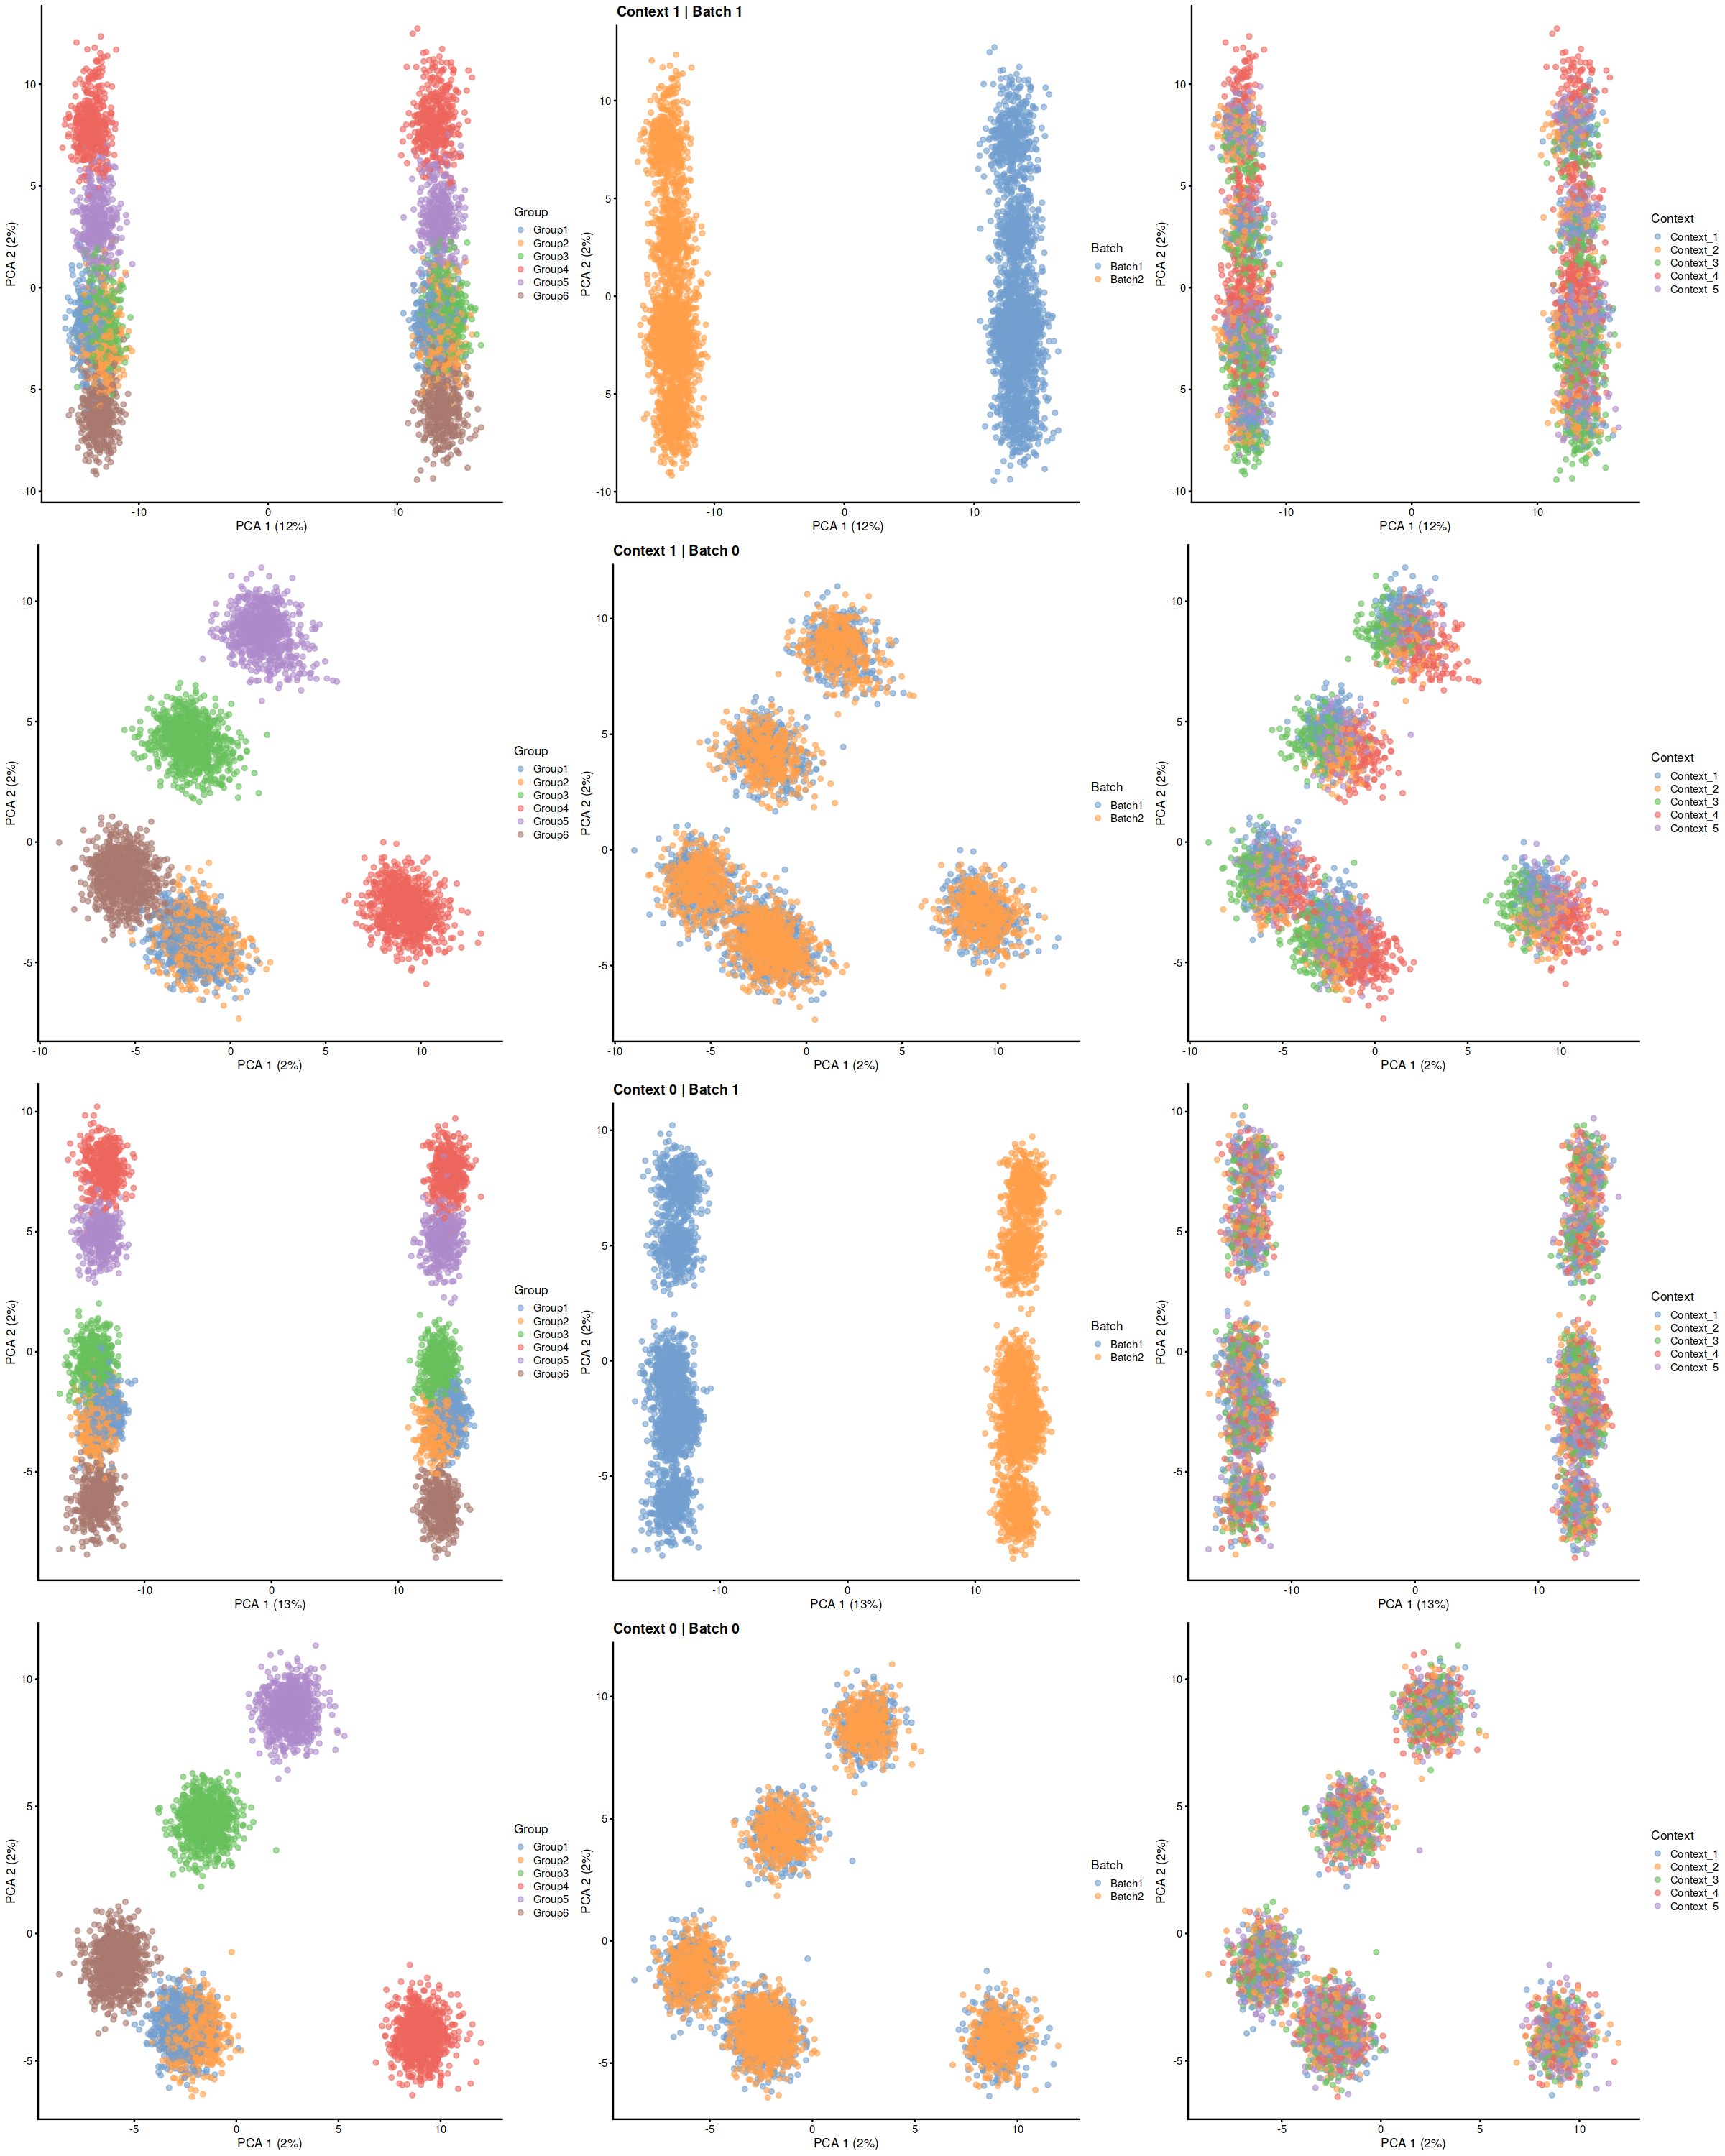

In [16]:
h_ = 25
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(expr.datasets$sim.log, colour_by = "Group")
g1b<-plotPCA(expr.datasets$sim.log, colour_by = "Batch") + ggtitle('Context 1 | Batch 1')
g1c<-plotPCA(expr.datasets$sim.log, colour_by = "Context")
g1<-ggpubr::ggarrange(g1a, g1b, g1c, ncol = 3)

g2a<-plotPCA(expr.datasets$sim.gold, colour_by = "Group")
g2b<-plotPCA(expr.datasets$sim.gold, colour_by = "Batch") + ggtitle('Context 1 | Batch 0')
g2c<-plotPCA(expr.datasets$sim.gold, colour_by = "Context")
g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3) 

g3a<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Group")
g3b<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Batch") + ggtitle('Context 0 | Batch 1')
g3c<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Context")
g3<-ggpubr::ggarrange(g3a, g3b, g3c, ncol = 3)

g4a<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Group")
g4b<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Batch") + ggtitle('Context 0 | Batch 0')
g4c<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Context")
g4<-ggpubr::ggarrange(g4a, g4b, g4c, ncol = 3) 

g4<-ggpubr::ggarrange(g1,g2,g3,g4, ncol = 1) 
g4

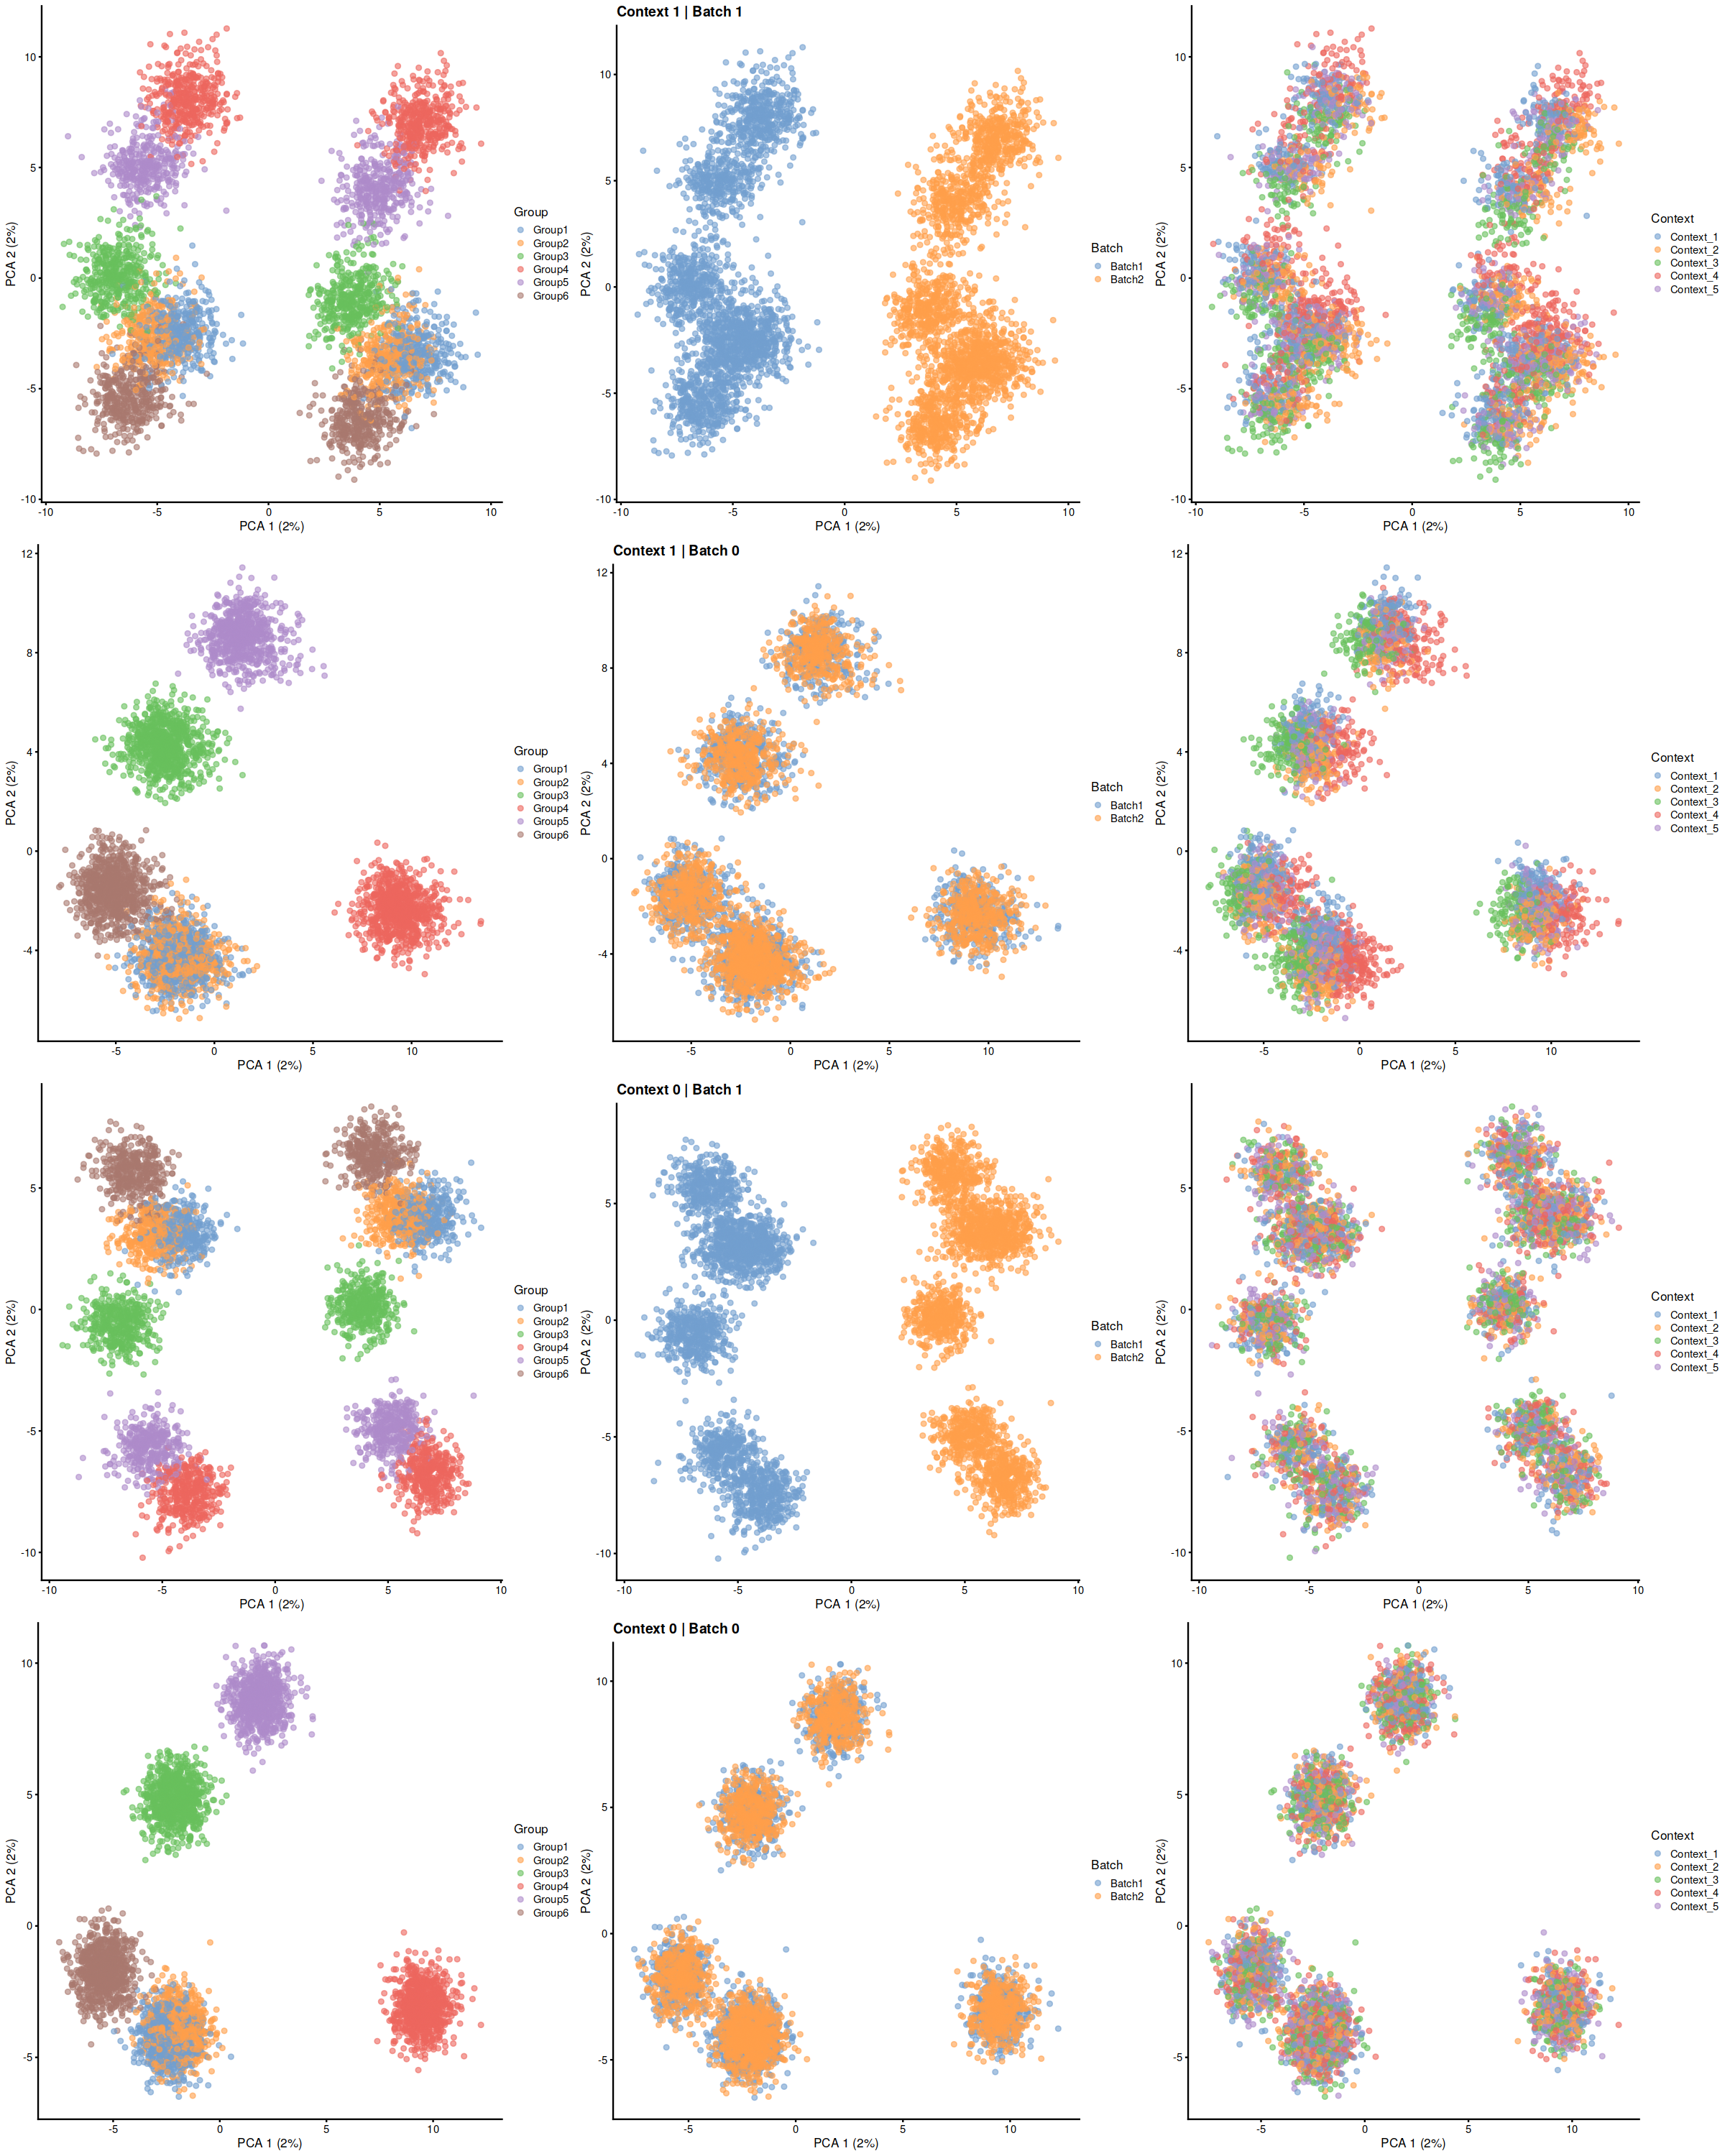

In [17]:
iter.params.list = list()
iter.params.list[[1]] = list(n.batches = 2, batch.scale = 0.1, batch.location = 0.1)
iter.params<-iter.params.list[[1]]

sim_params <- setParams(
    baseline_params,
    
    # batches
    batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
    batch.facLoc = iter.params$batch.location, # higher values increase batch severity
    batch.facScale = iter.params$batch.scale, # higher values increase batch severity
    batch.rmEffect = FALSE, # create the gold standard when set to True

)

sim<-splatSimulateGroups(sim_params, verbose = F)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

expr.datasets.nc<-expr.datasets
expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, context.noise, contexts))
                      
expr.datasets<-lapply(expr.datasets, FUN = function(sce) qc.data(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) qc.data(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scater::logNormCounts(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scater::logNormCounts(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))

                         
intersect.cells<-Reduce(intersect, list(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold), 
                       colnames(expr.datasets.nc$sim.log), colnames(expr.datasets.nc$sim.gold)))
expr.datasets<-lapply(expr.datasets, FUN = function(sce) sce[, intersect.cells])
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) sce[, intersect.cells])
                         
for (i in seq_along(expr.datasets.nc)){
    sce<-expr.datasets.nc[[i]]
    colData(sce)[['Context']] = colData(expr.datasets$sim.log)$Context
    expr.datasets.nc[[i]]<-sce
}

h_ = 25
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(expr.datasets$sim.log, colour_by = "Group")
g1b<-plotPCA(expr.datasets$sim.log, colour_by = "Batch") + ggtitle('Context 1 | Batch 1')
g1c<-plotPCA(expr.datasets$sim.log, colour_by = "Context")
g1<-ggpubr::ggarrange(g1a, g1b, g1c, ncol = 3)

g2a<-plotPCA(expr.datasets$sim.gold, colour_by = "Group")
g2b<-plotPCA(expr.datasets$sim.gold, colour_by = "Batch") + ggtitle('Context 1 | Batch 0')
g2c<-plotPCA(expr.datasets$sim.gold, colour_by = "Context")
g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3) 

g3a<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Group")
g3b<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Batch") + ggtitle('Context 0 | Batch 1')
g3c<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Context")
g3<-ggpubr::ggarrange(g3a, g3b, g3c, ncol = 3)

g4a<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Group")
g4b<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Batch") + ggtitle('Context 0 | Batch 0')
g4c<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Context")
g4<-ggpubr::ggarrange(g4a, g4b, g4c, ncol = 3) 

g4<-ggpubr::ggarrange(g1,g2,g3,g4, ncol = 1) 
g4

# Iterate Batch Effects

In [18]:
n.batches<-c(2, 4, 5) # 8
batch.locations<-c(0.01, 0.05, seq(0.1, 0.5, 0.1))
batch.scales<-c(0.01, 0.05, seq(0.1, 0.5, 0.1))

iter.params.list<-list()
counter<-1
for (nb in n.batches){
    for (bs in batch.scales){
        for (bl in batch.locations){
            iter.params.list[[counter]]<-list(n.batches = nb, 
                                             batch.scale = bs, 
                                             batch.location = bl)
            counter<-counter + 1
        }
    }
}

print(paste0('The number of iterations is: ', length(iter.params.list)))

[1] "The number of iterations is: 147"


In [67]:
# # count.types.names<-c('gold', 'log', 'scanorama', 'scvi')
# res.col.names<-c('iteration', 'n.batches', 'batch.scale', 'batch.location', 
#                  sapply(unlist(lapply(count.types.names, function(a) lapply(c('clusterability.kmeans', 'clusterability.louvain', 'mixability'), function (b) c(a, b))), recursive=FALSE), 
#                     function(x) paste0(x, collapse = '_')), 
#                   sapply(unlist(lapply(c('natmi', 'sca'), 
#               function(a) lapply(count.types.names[2:4], function (b) c(a, b))), recursive=FALSE), 
#         function(x) paste0('frac_0_', 'corr.index_', x[[2]], '_', x[[1]])),
#                 sapply(unlist(lapply(c('natmi', 'sca'), 
#               function(a) lapply(count.types.names[2:4], function (b) c(a, b))), recursive=FALSE), 
#         function(x) paste0('frac_0.1_', 'corr.index_', x[[2]], '_', x[[1]])),
#                 sapply(unlist(lapply(c('frac_0', 'frac_0.1'), function(a) lapply(c('natmi', 'sca'), function (b) c(a, b))), recursive=FALSE), 
#                     function(x) paste0(c('n.tensor.elements', x), collapse = '_')), 
#               c('scanorama_frac.negative', 'scvi_frac.negative'),
#         sapply(unlist(lapply(c('frac_0', 'frac_0.1'), function(a) lapply(c('natmi', 'sca'), function (b) c(a, b))), recursive=FALSE), 
#                     function(x) paste0(c('rank', x), collapse = '_'))
#                )                                                            

count.types.names<-c('gold', 'log', 'scanorama', 'scvi')
res.col.names<-c('iteration', 'n.batches', 'batch.scale', 'batch.location', 
                 sapply(unlist(lapply(count.types.names, function(a) lapply(c('clusterability.kmeans', 'clusterability.louvain', 'mixability'), function (b) c(a, b))), recursive=FALSE), 
                    function(x) paste0(x, collapse = '_')),
                 'n.tensor.elements', 'scanorama_frac.negative', 'scvi_frac.negative',
                 'corr.index.log', 'corrindex.scanorama', 'corrindex.scvi') 
res.df <- data.frame(matrix(ncol = length(res.col.names), nrow = 0))
colnames(res.df)<-res.col.names

iter<-1

# Begin Iteration

In [ ]:
iter<-1
for (iter.params in iter.params.list){
    print(iter)
    sim_params <- setParams(
        baseline_params,

        # batches
        batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
        batch.facLoc = iter.params$batch.location, # higher values increase batch severity
        batch.facScale = iter.params$batch.scale, # higher values increase batch severity
        batch.rmEffect = FALSE, # create the gold standard when set to True

    )

    print('process')
    sim<-splatSimulateGroups(sim_params, verbose = F)
    sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
    expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

    expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, context.noise, contexts))                      
    expr.datasets<-lapply(expr.datasets, FUN = function(sce) qc.data(sce))

    genes.intersect<-intersect(rownames(expr.datasets$sim.log), rownames(expr.datasets$sim.gold))
    cells.intersect<-intersect(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold))
    expr.datasets<-lapply(expr.datasets, FUN = function(sce) {
        sce <- sce[genes.intersect, cells.intersect] # retain only genes/cells in common b/w the 2 datasets
        sce <- scater::logNormCounts(sce)
    })

    print('Cluster A')                      
    for (cluster.method in c('louvain', 'kmeans')){
        expr.datasets<-lapply(expr.datasets, function(sce) cluster.cells(sce, assay.type = 'logcounts', 
                                                                             n.cell.types = n.cell.types, 
                                                                        cluster.method = cluster.method))
        # allow +-1 cluster if first attempt didnt find # of clusters = # of cell types
        if (cluster.method == 'louvain'){
            cluster.present<-sapply(expr.datasets, function(sce) check.cluster(sce))
            for (count.type in names(cluster.present[!cluster.present])){
                sce<-cluster.cells(expr.datasets[[count.type]], assay.type = 'logcounts', n.cell.types = n.cell.types, 
                                   cluster.range = cluster_tol, cluster.method = cluster.method)
                expr.datasets[[count.type]]<-sce
            }
        }
    }

    print('Batch correct')
    # batch correct 
    # #     # filter for HVGs after log-normalization
    # #     mgv<-scran::modelGeneVar(expr.datasets$gold.standard, assay.type = 'logcounts')
    # #     hvgs<-scran::getTopHVGs(mgv, n = n.hvgs)
    #     expr.datasets<-lapply(expr.datasets, FUN = function(sce) {
    # #         sce <- sce[hvg, ] # filter for HVGs from gold-standard dataset
    #         sce <- cluster.cells(sce, assay.type = 'logcounts') # run PCA and SNN clustering 
    #     })
    suppressMessages({sce.batches<-do.batch.correction(expr.datasets$sim.log)}) # on log-normalized data with batch effects 

    print('Cluster B')
    # cluster batch-corrected data
    for (cluster.method in c('louvain', 'kmeans')){
        sce.batches<-lapply(sce.batches, function(sce) cluster.cells(sce, assay.type = 'batch.corrected.counts', 
                                                                             n.cell.types = n.cell.types, 
                                                                        cluster.method = cluster.method))
        # allow +-1 cluster if first attempt didnt find # of clusters = # of cell types
        if (cluster.method == 'louvain'){
            cluster.present<-sapply(sce.batches, function(sce) check.cluster(sce))
            for (count.type in names(cluster.present[!cluster.present])){
                sce<-cluster.cells(sce.batches[[count.type]], assay.type = 'batch.corrected.counts', n.cell.types = n.cell.types, 
                                   cluster.range = cluster_tol, cluster.method = cluster.method)
                sce.batches[[count.type]]<-sce
            }
        }
    }

    print('Batch severity')
    # calculate batch severity
    batch.severity<-setNames(lapply(expr.datasets, function(sce) quantify.batch.effect(sce, assay.type = 'logcounts')), 
        names(expr.datasets))
    batch.severity<-c(batch.severity, 
                      setNames(lapply(sce.batches, function(sce) quantify.batch.effect(sce, assay.type = 'batch.corrected.counts')), 
                                names(sce.batches)))

    frac.negative<-lapply(sce.batches, function(sce) count.negative(assays(sce)$batch.corrected.counts))

    print('Score communication') # score communication
    sce.batches<-lapply(sce.batches, function(sce) replace.negative.counts(sce)) # also assigns batch corrected data to logcounts assay
    expr.datasets <- c(expr.datasets, sce.batches)

    comm.scores<-list()
    # for (expr.prop in c(0, 0.1)){

    for (count.type in names(expr.datasets)){
        sce<-expr.datasets[[count.type]]
        sce.list<-split.by.context(sce, context_lab = 'Context')

        comm.scores.context<-list()
        for (context in names(sce.list)){
            comm.scores.context[[context]]<-score.communication(sce_ = sce.list[[context]], 
                                           method = c('cellphonedb', 'natmi', 'sca'), # only the ones with a magnitude score
                                           idents_col = 'Group', 
                                           assay.type = 'logcounts', # all are assigned to logcounts, including batch-corrected
                                           return_all = return_all, 
                                           expr_prop = 0.05, 
                                           seed = seed,
                                           parallelize = T, 
                                           workers = n.cores, 
                                           permutation.params = list(nperms = 1), # since we don't use p-values
                                           resource = 'custom',
                                           external_resource = lr.ppi)
            }

        comm.scores[[count.type]]<-comm.scores.context
    }

    print('Tensors') # tensors
    tensor.list<-list()
    if (repeat_rank){
        stop('Must account for re-calculating rank each iteration in code')
    }else{
        for (counts.type in names(expr.datasets)){
            suppressMessages({
                tensor.iter<-liana_tensor_c2c(context_df_dict = comm.scores[[counts.type]],
                                   score_col = 'score',
                                   ligand_col = 'ligand', 
                                   receptor_col = 'receptor', 
                                   lr_fill = NaN, 
                                   cell_fill = NaN,
                                   how = 'outer',
                                   seed = seed, 
                                   conda_env = env.name,
                                   device = NULL,
                                   build_only = T)
                if (gpu_use){
                    tensorly$set_backend('pytorch')
                    tensor.iter$to_device('cuda')
                }

                # identify the rank and run the decomposition
                tensor.iter<-liana::decompose_tensor(tensor = tensor.iter,
                                                       rank = tensor.baseline.context$rank, 
                                                       tf_optimization = 'regular', 
                                                       seed = seed, 
                                                       init = 'svd', 
                                                       factors_only = F, 
                                                       ) # estimate the rank by setting to NULL
            })
            if (gpu_use)({tensorly$set_backend('numpy')}) # need to change back to be able to manipulate masks, etc
            tensor.list[[counts.type]]<-tensor.iter
        }
    }

    td<-tensor.list$sim.gold$tensor$shape
    tensor.elements<-td[0] * td[1] * td[2] * td[3]                    

    print('CorrIndex')
    corr.index<-list()
    tensor.gold<-tensor.list$sim.gold

    for (counts.type in names(expr.datasets)[2:length(expr.datasets)]){
        tensor<-tensor.list[[counts.type]]
        if (identical(dim(tensor.gold$tensor), dim(tensor$tensor))){
            similarity.score<-(1 - (c2c$tensor$metrics$correlation_index(tensor.gold$factors, 
                                                          tensor$factors)))
        }
        else{
            similarity.score<-NA # rare instances when expr_prop = 0.05 filters out some LRs
        }
        corr.index[[counts.type]]<- similarity.score
    }

    print('save') # save
    res<-c(iter, unname(unlist(iter.params)), 
           unname(unlist(batch.severity)), 
           tensor.elements, unname(unlist(frac.negative)), 
           unlist(unname(corr.index)))
    names(res)<-res.col.names
    res.df<-rbind(res.df, t(as.data.frame(res)))
    write.csv(res.df, paste0(data.path, 'interim/', 'clustertol', cluster_tol, '_batch_correction_benchmark.csv'))
    iter<-iter + 1
}
print('complete')